In [1]:
import gym
import random
import numpy as np


#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

from keras import layers
from skimage.color import rgb2gray
from skimage.transform import resize
from keras.models import Model
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
from collections import deque
from keras.optimizers import RMSprop
from keras import backend as K
from datetime import datetime
import os.path
import time
from keras.models import load_model
from keras.models import clone_model
from keras.callbacks import TensorBoard
from keras.models import model_from_json


from matplotlib import pyplot as plt
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10




FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('train_dir', 'tf_train_breakout',
                           """Directory where to write event logs and checkpoint. """)
tf.app.flags.DEFINE_string('restore_file_path',
                           'tf_train_breakout/breakout_model_retrain_downloaded',
                           """Path of the restore file """)
tf.app.flags.DEFINE_integer('num_episode', 100000,
                            """number of epochs of the optimization loop.""")
tf.app.flags.DEFINE_integer('observe_step_num', 5,
                            """Timesteps to observe before training.""")
tf.app.flags.DEFINE_integer('epsilon_step_num', 1000000,
                            """frames over which to anneal epsilon.""")
tf.app.flags.DEFINE_integer('refresh_target_model_num', 10000,  # update the target Q model every refresh_target_model_num
                            """frames over which to anneal epsilon.""")
tf.app.flags.DEFINE_integer('replay_memory', 50000,  # takes up to 20 GB to store this amount of history data
                            """number of previous transitions to remember.""")
tf.app.flags.DEFINE_integer('no_op_steps', 30,
                            """Number of the steps that runs before script begin.""")
tf.app.flags.DEFINE_float('regularizer_scale', 0.01,
                          """L1 regularizer scale.""")
tf.app.flags.DEFINE_integer('batch_size', 4,
                            """Size of minibatch to train.""")
tf.app.flags.DEFINE_float('learning_rate', 0.00025,
                          """Number of batches to run.""")
tf.app.flags.DEFINE_float('init_epsilon', 1.0,
                          """starting value of epsilon.""")
tf.app.flags.DEFINE_float('final_epsilon', 0.1,
                          """final value of epsilon.""")
tf.app.flags.DEFINE_float('gamma', 0.99,
                          """decay rate of past observations.""")
tf.app.flags.DEFINE_boolean('resume', False,
                            """Whether to resume from previous checkpoint.""")
tf.app.flags.DEFINE_boolean('render', True,
                            """Whether to display the game.""")


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frames (InputLayer)             (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
normalization (Lambda)          (None, 84, 84, 4)    0           frames[0][0]                     
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 20, 20, 16)   4112        normalization[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 9, 9, 32)     8224        conv2d_5[0][0]                   
____________________________________________________________________________________________

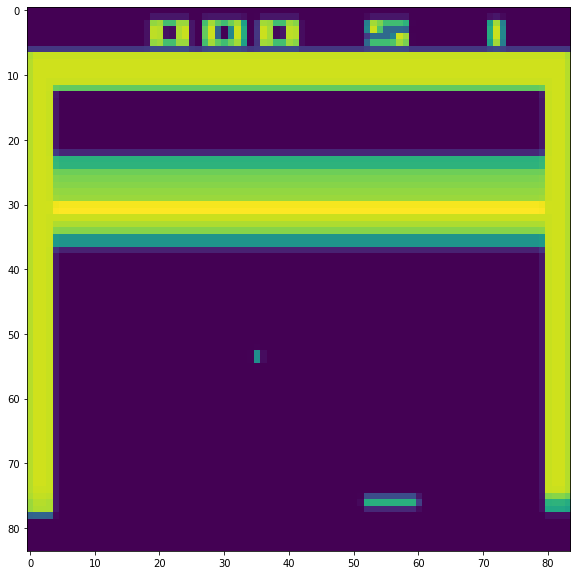

(84, 84)


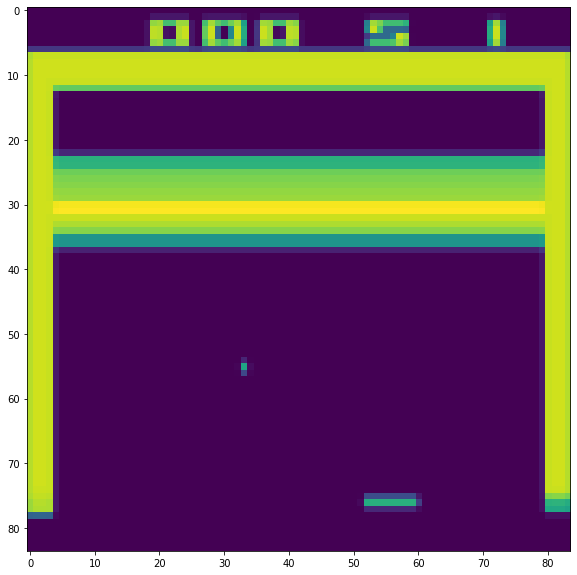

(84, 84)


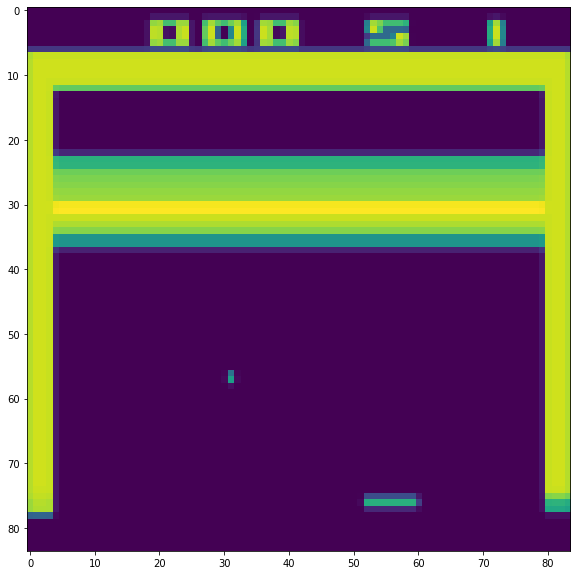

(84, 84)


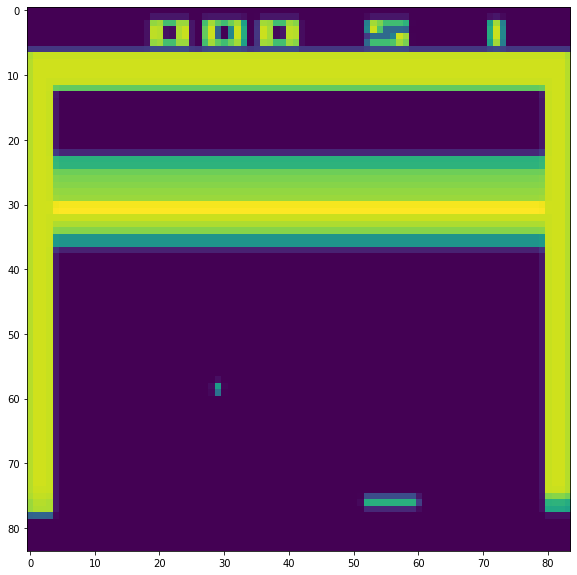

(84, 84)


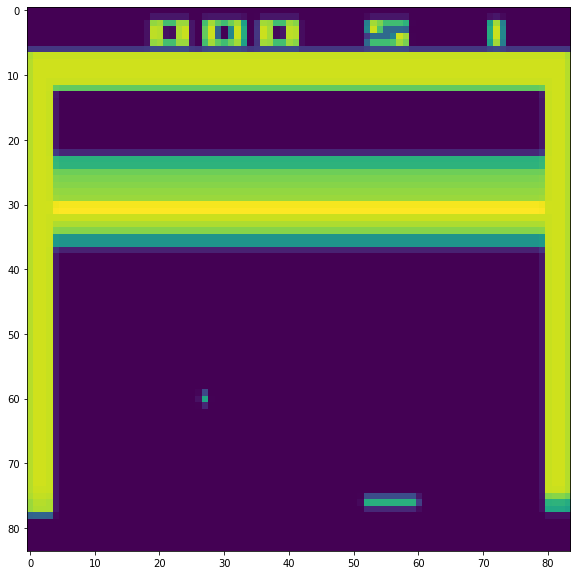

(84, 84)


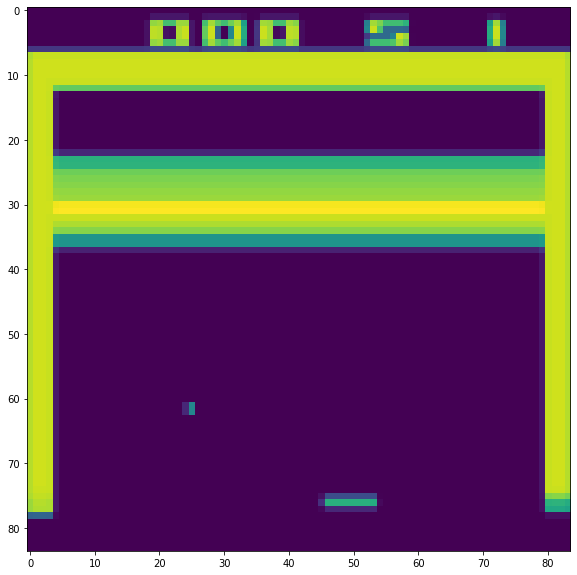

(84, 84)


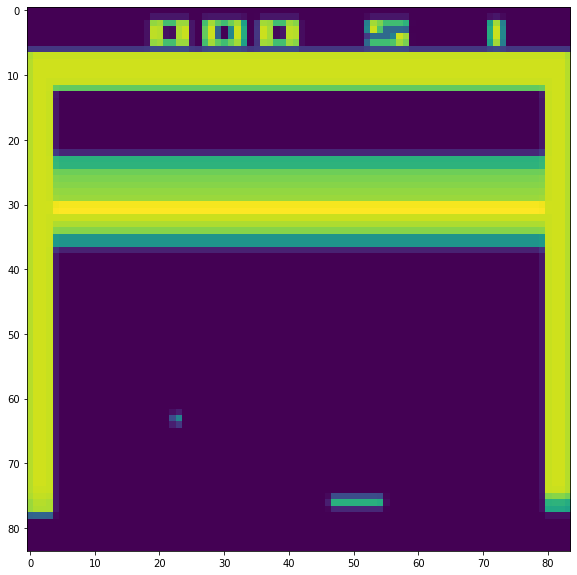

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


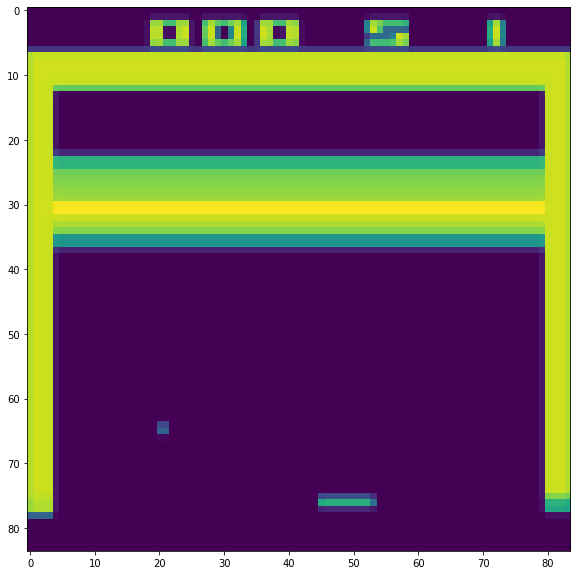

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


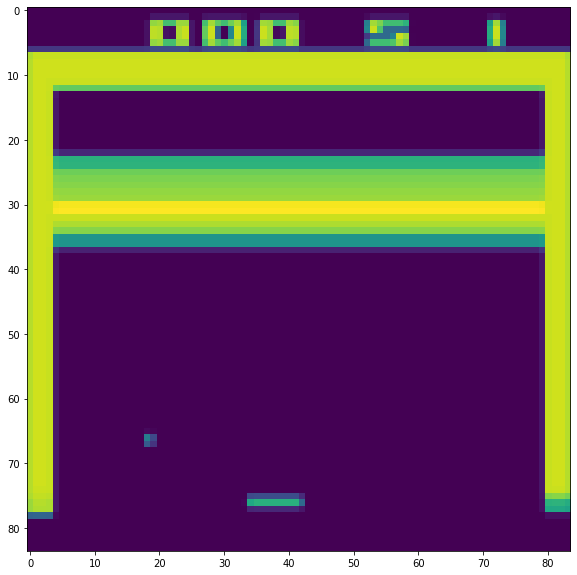

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


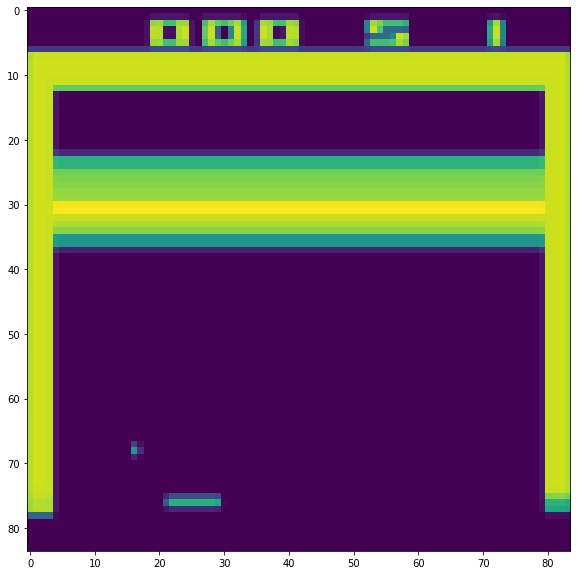

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


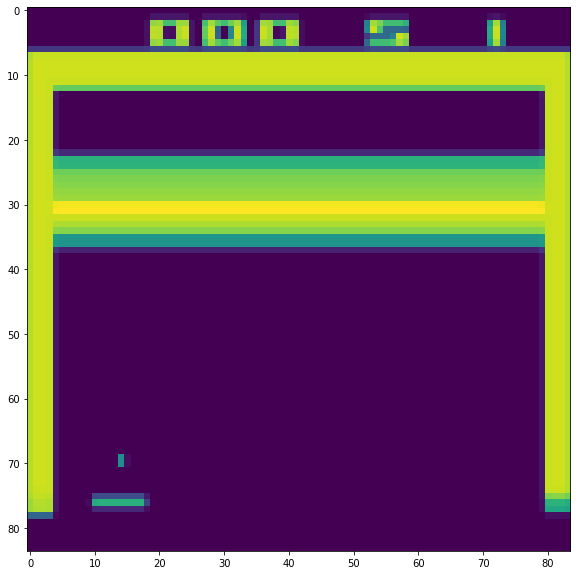

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


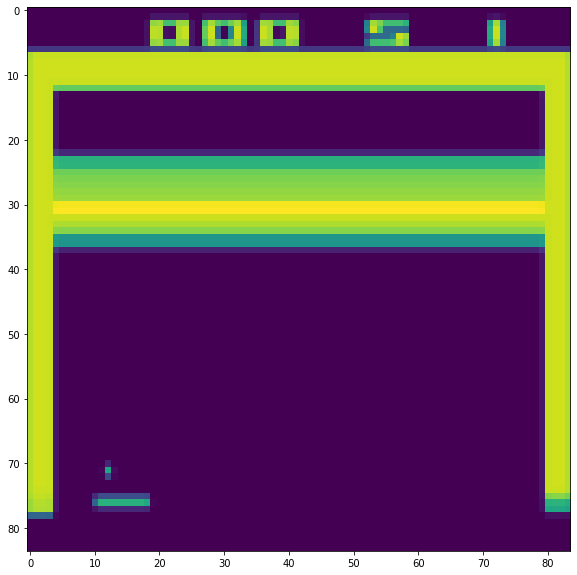

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


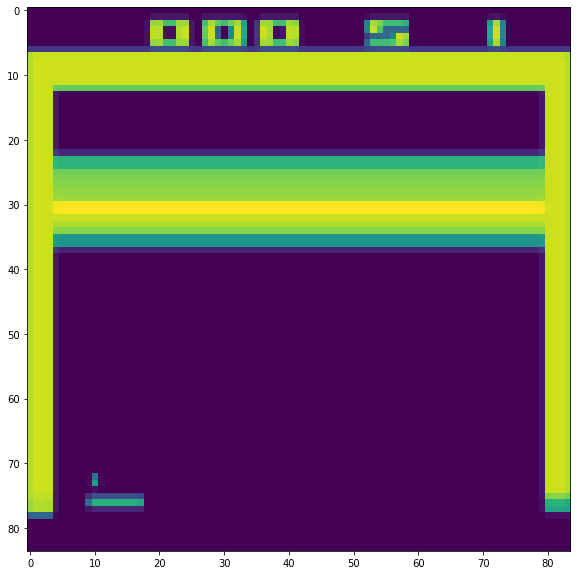

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


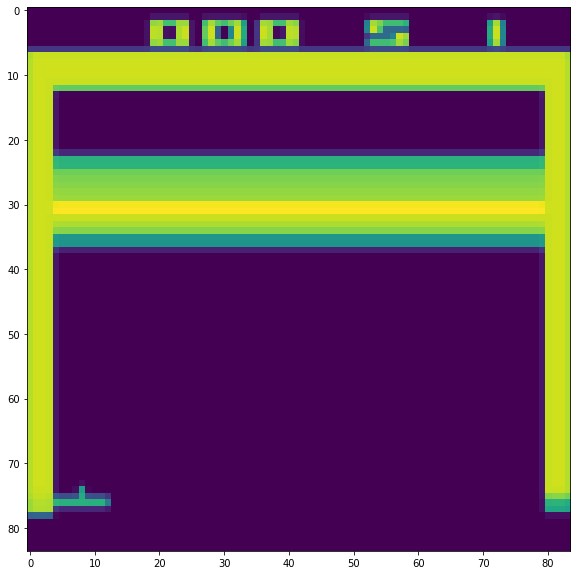

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


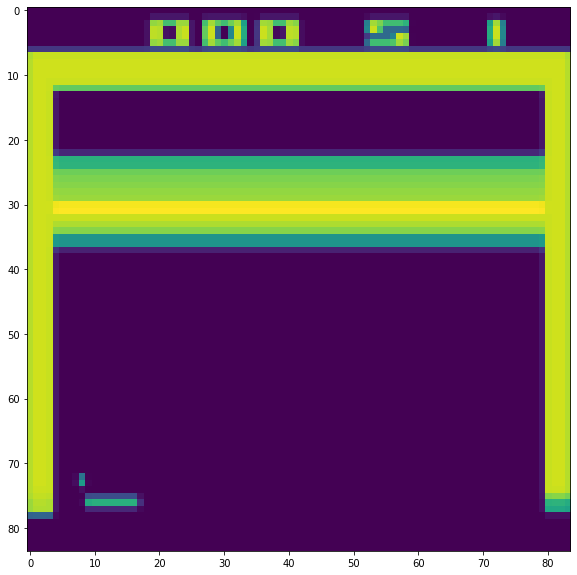

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


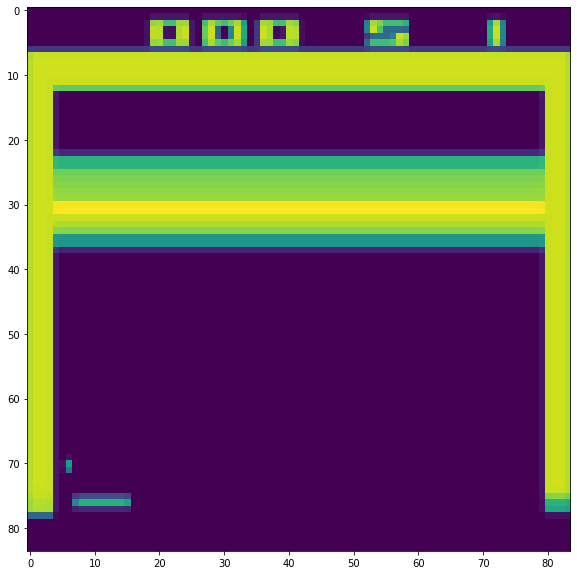

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


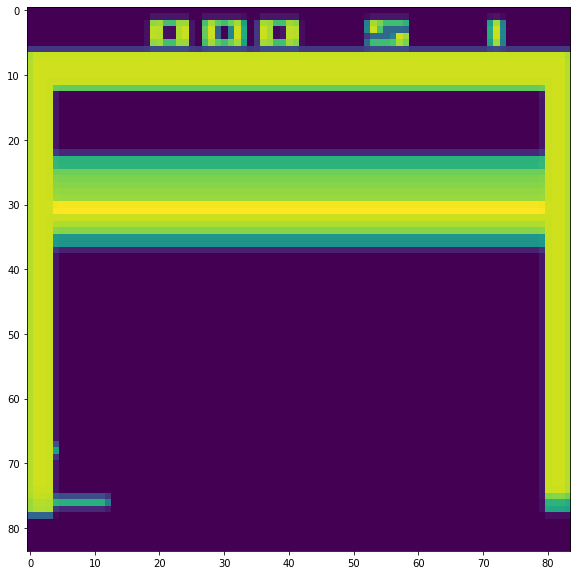

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


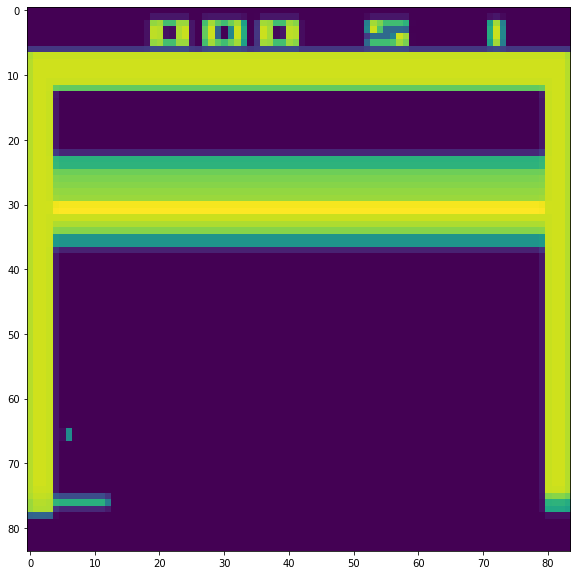

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


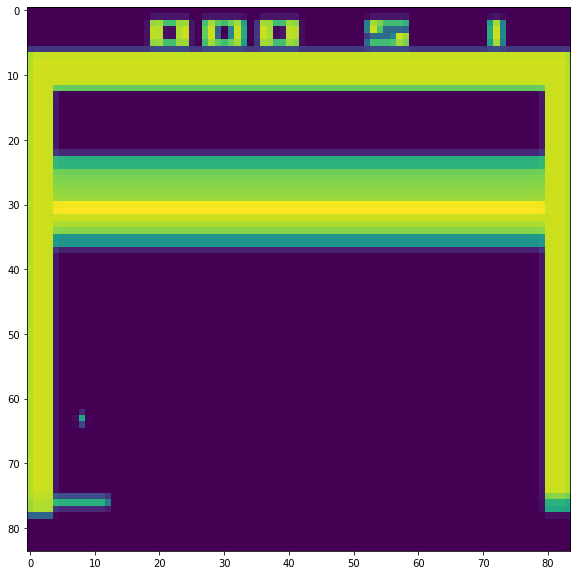

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


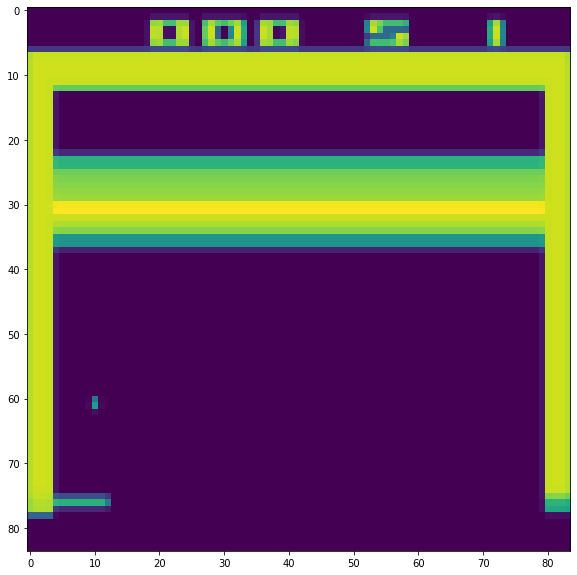

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


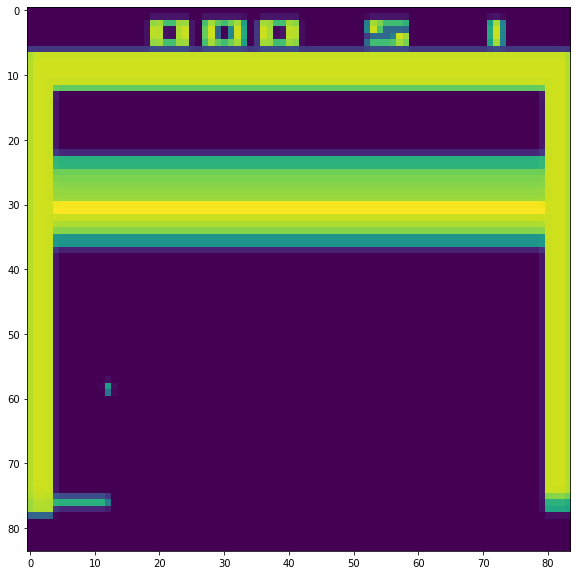

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


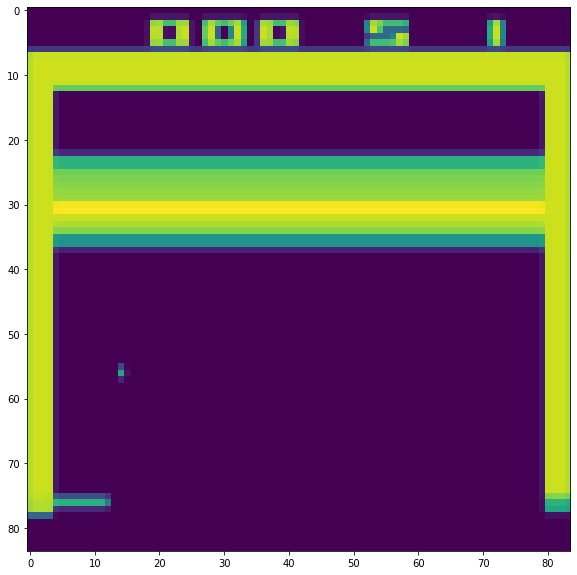

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


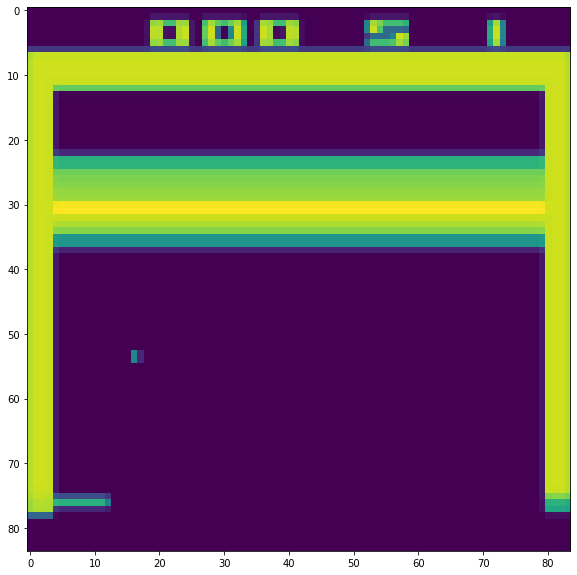

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


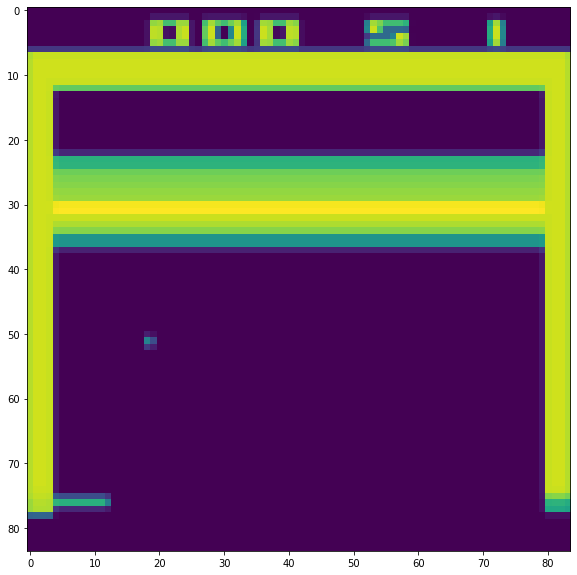

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


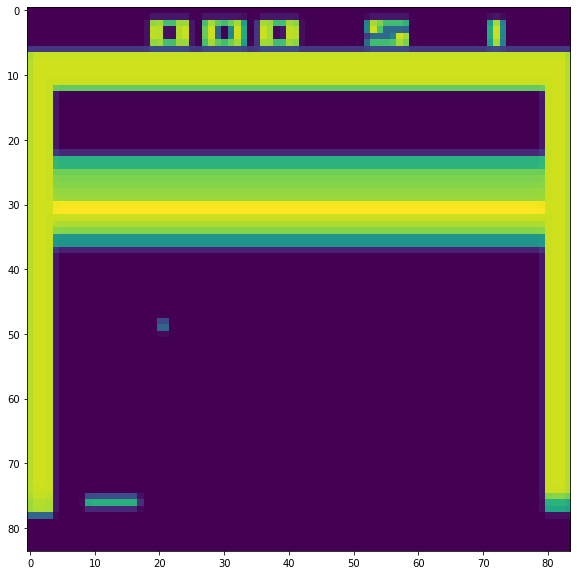

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


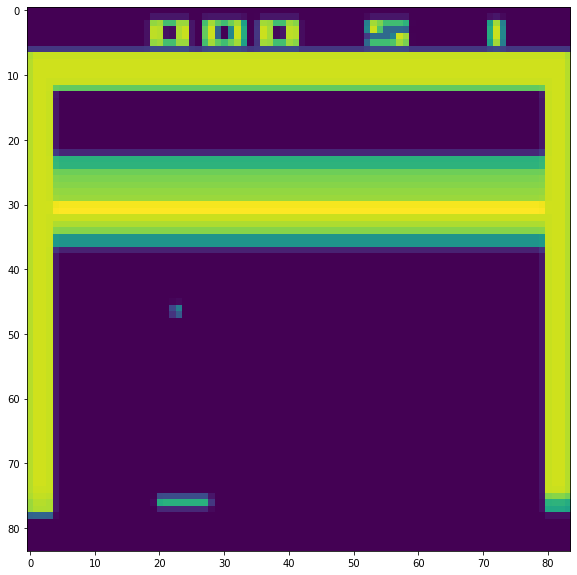

(84, 84)
(84, 84, 4)
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


KeyboardInterrupt: 

In [4]:

ATARI_SHAPE = (84, 84, 4)  # input image size to model
ACTION_SIZE = 3


now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
now = 'breakout_skratch'

scores = []
averages = []
episodes = []

# 210*160*3(color) --> 84*84(mono)
# float --> integer (to reduce the size of replay memory)
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe


def huber_loss(y, q_value):
    error = K.abs(y - q_value)
    quadratic_part = K.clip(error, 0.0, 1.0)
    linear_part = error - quadratic_part
    loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)
    return loss


def atari_model():
    # With the functional API we need to define the inputs.
    frames_input = layers.Input(ATARI_SHAPE, name='frames')
    actions_input = layers.Input((ACTION_SIZE,), name='action_mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = layers.Lambda(lambda x: x / 255.0, name='normalization')(frames_input)

    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = layers.convolutional.Conv2D(
        16, (8, 8), strides=(4, 4), activation='relu'
    )(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = layers.convolutional.Conv2D(
        32, (4, 4), strides=(2, 2), activation='relu'
    )(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = layers.Dense(ACTION_SIZE)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = layers.Multiply(name='QValue')([output, actions_input])

    model = Model(inputs=[frames_input, actions_input], outputs=filtered_output)
    model.summary()
    optimizer = RMSprop(lr=FLAGS.learning_rate, rho=0.95, epsilon=0.01)
    # model.compile(optimizer, loss='mse')
    # to changed model weights more slowly, uses MSE for low values and MAE(Mean Absolute Error) for large values
    model.compile(optimizer, loss=huber_loss)
    return model


# get action from model using epsilon-greedy policy
def get_action(history, epsilon, step, model):
    if np.random.rand() <= epsilon or step <= FLAGS.observe_step_num:
        return random.randrange(ACTION_SIZE)
    else:
        q_value = model.predict([history, np.ones(ACTION_SIZE).reshape(1, ACTION_SIZE)])
        return np.argmax(q_value[0])


# save sample <s,a,r,s'> to the replay memory
def store_memory(memory, history, action, reward, next_history, dead):
    memory.append((history, action, reward, next_history, dead))


def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]


# train model by random batch
def train_memory_batch(memory, model, log_dir):
    mini_batch = random.sample(memory, FLAGS.batch_size)
    history = np.zeros((FLAGS.batch_size, ATARI_SHAPE[0],
                        ATARI_SHAPE[1], ATARI_SHAPE[2]))
    next_history = np.zeros((FLAGS.batch_size, ATARI_SHAPE[0],
                             ATARI_SHAPE[1], ATARI_SHAPE[2]))
    target = np.zeros((FLAGS.batch_size,))
    action, reward, dead = [], [], []

    for idx, val in enumerate(mini_batch):
        history[idx] = val[0]
        next_history[idx] = val[3]
        action.append(val[1])
        reward.append(val[2])
        dead.append(val[4])

    actions_mask = np.ones((FLAGS.batch_size, ACTION_SIZE))
    print(next_history[0].shape)
    print(next_history[0])
    next_Q_values = model.predict([next_history, actions_mask])

    # like Q Learning, get maximum Q value at s'
    # But from target model
    for i in range(FLAGS.batch_size):
        if dead[i]:
            target[i] = -1
            # target[i] = reward[i]
        else:
            target[i] = reward[i] + FLAGS.gamma * np.amax(next_Q_values[i])

    action_one_hot = get_one_hot(action, ACTION_SIZE)
    target_one_hot = action_one_hot * target[:, None]

    #tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,
    #                          write_graph=True, write_images=False)

    ''''''
    h = model.fit(
        [history, action_one_hot], target_one_hot, epochs=1,
        batch_size=FLAGS.batch_size, verbose=0)
        #batch_size=FLAGS.batch_size, verbose=0, callbacks=[tb_callback])

    #if h.history['loss'][0] > 10.0:
    #    print('too large')

    return h.history['loss'][0]

def train():
    env = gym.make('BreakoutDeterministic-v4')

    # deque: Once a bounded length deque is full, when new items are added,
    # a corresponding number of items are discarded from the opposite end
    memory = deque(maxlen=FLAGS.replay_memory)
    episode_number = 0
    epsilon = FLAGS.init_epsilon
    epsilon_decay = (FLAGS.init_epsilon - FLAGS.final_epsilon) / FLAGS.epsilon_step_num
    global_step = 0

    if FLAGS.resume:
        
        # load json and create model
        json_file = open(FLAGS.restore_file_path+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights(FLAGS.restore_file_path+'.h5')
        
        optimizer = RMSprop(lr=FLAGS.learning_rate, rho=0.95, epsilon=0.01)
        # model.compile(optimizer, loss='mse')
        # to changed model weights more slowly, uses MSE for low values and MAE(Mean Absolute Error) for large values
        model.compile(optimizer, loss=huber_loss)
        
        print("Loaded model from disk")
        '''
        model = load_model('tf_train_breakout/breakout_model_20180610205843_36h_12193ep_sec_version_back.h5')#, custom_objects={'huber_loss': huber_loss})
        print("Loaded model from disk")
        #model = load_model(FLAGS.restore_file_path)
        '''
        #model = load_model(FLAGS.restore_file_path)
        # Assume when we restore the model, the epsilon has already decreased to the final value
        epsilon = FLAGS.final_epsilon
    else:
        model = atari_model()

    log_dir = "logs/{}/run-{}-log".format(FLAGS.train_dir, now)
    file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

    model_target = clone_model(model)
    model_target.set_weights(model.get_weights())

    while episode_number < FLAGS.num_episode:

        done = False
        dead = False
        # 1 episode = 5 lives
        step, score, start_life = 0, 0, 5
        loss = 0.0
        observe = env.reset()

        # this is one of DeepMind's idea.
        # just do nothing at the start of episode to avoid sub-optimal
        for _ in range(random.randint(1, FLAGS.no_op_steps)):
            observe, _, _, _ = env.step(1)
        # At start of episode, there is no preceding frame
        # So just copy initial states to make history
        state = pre_processing(observe)
        history = np.stack((state, state, state, state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        while not done:
            if FLAGS.render:
                env.render()
                time.sleep(0.01)

            # get action for the current history and go one step in environment
            action = get_action(history, epsilon, global_step, model_target)
            # change action to real_action
            real_action = action + 1

            # scale down epsilon, the epsilon only begin to decrease after observe steps
            if epsilon > FLAGS.final_epsilon and global_step > FLAGS.observe_step_num:
                epsilon -= epsilon_decay

            observe, reward, done, info = env.step(real_action)
            # pre-process the observation --> history
            next_state = pre_processing(observe)
            plt.imshow(next_state)
            plt.show()
            print(next_state.shape)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            #print('state:', next_state[0].shape)
            #print('state:', next_state[0])
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            # if the agent missed ball, agent is dead --> episode is not over
            if start_life > info['ale.lives']:
                dead = True
                start_life = info['ale.lives']

            # TODO: may be we should give negative reward if miss ball (dead)
            # reward = np.clip(reward, -1., 1.)  # clip here is not correct

            # save the statue to memory, each replay takes 2 * (84*84*4) bytes = 56448 B = 55.125 KB
            store_memory(memory, history, action, reward, next_history, dead)  #

            # check if the memory is ready for training
            if global_step > FLAGS.observe_step_num:
                loss = loss + train_memory_batch(memory, model, log_dir)
                # if loss > 100.0:
                #    print(loss)
                if global_step % FLAGS.refresh_target_model_num == 0:  # update the target model
                    model_target.set_weights(model.get_weights())

            score += reward

            # If agent is dead, set the flag back to false, but keep the history unchanged,
            # to avoid to see the ball up in the sky
            if dead:
                dead = False
            else:
                history = next_history

            #print("step: ", global_step)
            global_step += 1
            step += 1

            if done:
                if global_step <= FLAGS.observe_step_num:
                    state = "observe"
                elif FLAGS.observe_step_num < global_step <= FLAGS.observe_step_num + FLAGS.epsilon_step_num:
                    state = "explore"
                else:
                    state = "train"
                print('state: {}, episode: {}, score: {}, global_step: {}, avg loss: {}, step: {}, memory length: {}'
                      .format(state, episode_number, score, global_step, loss / float(step), step, len(memory)))

                if episode_number % 100 == 0 or (episode_number + 1) == FLAGS.num_episode:
                #if episode_number % 1 == 0 or (episode_number + 1) == FLAGS.num_episode:  # debug
                    file_name = "breakout_model_{}".format(now)
                    model_path = os.path.join(FLAGS.train_dir, file_name)
                    
                    # serialize model to JSON
                    model_json = model.to_json()
                    with open(model_path+'.json', "w") as json_file:
                        json_file.write(model_json)
                    # serialize weights to HDF5
                    model.save_weights(model_path+'.h5')
                    #model.save(model_path)

                # Add user custom data to TensorBoard
                loss_summary = tf.Summary(
                    value=[tf.Summary.Value(tag="loss", simple_value=loss / float(step))])
                file_writer.add_summary(loss_summary, global_step=episode_number)

                score_summary = tf.Summary(
                    value=[tf.Summary.Value(tag="score", simple_value=score)])
                file_writer.add_summary(score_summary, global_step=episode_number)

                episode_number += 1
                PlotModel(score, episode_number)


    file_writer.close()


def PlotModel(score, episode_number):
    scores.append(score)
    averages.append(sum(scores[-50:]) / len(scores[-50:]))
    episodes.append(episode_number)
    pylab.plot(episodes, scores, 'b')
    pylab.plot(episodes, averages, 'r')
    pylab.ylabel('Score', fontsize=18)
    pylab.xlabel('Games', fontsize=18)
    file_name = "breakout_model_{}".format(now)
    name = file_name + '.png'
    try:
        if not os.path.exists('training_images'): os.makedirs('training_images')
        pylab.savefig('training_images/'+name)

    except OSError as e:
        print(e)
        pass
    return             
                
     
                
                
                
def main(argv=None):
    train()
    #test()


if __name__ == '__main__':
    tf.app.run()



In [ ]:

def test():
    env = gym.make('BreakoutDeterministic-v4')

    episode_number = 0
    epsilon = 0.001
    global_step = FLAGS.observe_step_num+1
    
    # load json and create model
    json_file = open(FLAGS.restore_file_path+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(FLAGS.restore_file_path+'.h5')
    print("Loaded model from disk")
    
    #model = load_model('tf_train_breakout/breakout_model_20180610205843_36h_12193ep_sec_version_back.h5')#, custom_objects={'huber_loss': huber_loss})
    #model = load_model('tf_train_breakout/breakout_model_20180606123015_24h_4221ep_first_version_back.h5', custom_objects={'huber_loss': huber_loss})
    #model = load_model(FLAGS.restore_file_path, custom_objects={'huber_loss': huber_loss})  # load model with customized loss func

    # test how to deep copy a model
    '''
    model_copy = clone_model(model)    # only copy the structure, not the value of the weights
    model_copy.set_weights(model.get_weights())
    '''

    while episode_number < FLAGS.num_episode:

        done = False
        dead = False
        # 1 episode = 5 lives
        score, start_life = 0, 5
        observe = env.reset()

        observe, _, _, _ = env.step(1)
        # At start of episode, there is no preceding frame
        # So just copy initial states to make history
        state = pre_processing(observe)
        history = np.stack((state, state, state, state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        while not done:
            env.render()
            time.sleep(0.01)

            # get action for the current history and go one step in environment
            action = get_action(history, epsilon, global_step, model)
            # change action to real_action
            real_action = action + 1

            observe, reward, done, info = env.step(real_action)
            # pre-process the observation --> history
            next_state = pre_processing(observe)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            # if the agent missed ball, agent is dead --> episode is not over
            if start_life > info['ale.lives']:
                dead = True
                start_life = info['ale.lives']

            # TODO: may be we should give negative reward if miss ball (dead)
            reward = np.clip(reward, -1., 1.)

            score += reward

            # If agent is dead, set the flag back to false, but keep the history unchanged,
            # to avoid to see the ball up in the sky
            if dead:
                dead = False
            else:
                history = next_history

            # print("step: ", global_step)
            global_step += 1

            if done:
                episode_number += 1
                print('episode: {}, score: {}'.format(episode_number, score))
                
                
